In [1]:
import pandas as pd
import numpy as np
from sklearn.utils import shuffle
from datetime import datetime 
import multiprocessing
from bs4 import BeautifulSoup as bs
from selectolax.parser import HTMLParser
import re
import pymorphy2
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import string
import pickle


#preprocessing
import re
import pymorphy2
import nltk
from nltk.corpus import stopwords  #stopwords
from nltk import word_tokenize,sent_tokenize # tokenizing
from nltk.stem import PorterStemmer,LancasterStemmer  # using the Porter Stemmer and Lancaster Stemmer and others
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer  # lammatizer from WordNet
import matplotlib.pyplot as plt
import string

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from livelossplot.tf_keras import PlotLossesCallback
from time import time  # To time our operations
from collections import defaultdict, Counter  # For word frequency


import logging  # Setting up the loggings to monitor gensim
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)

import warnings
warnings.filterwarnings('ignore')

# import logging  # Setting up the loggings to monitor gensim
# logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)

import warnings
warnings.filterwarnings('ignore')

In [2]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /Users/adwiz/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/adwiz/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
# Data loading and preparation
data = pd.read_json('../datasets/dataset.json')
mapping = {False: 0, True: 1}
data.replace({'hasBadWords': mapping}, inplace=True)
# data.hasBadWords = data.hasBadWords.apply(lambda x: 1 if x == True else 0)
data.rename(columns={"hasBadWords": "labels"}, inplace=True)
data.drop(['violation'], axis=1, inplace=True)
data.shape

RANDOM_STATE = 42

data = shuffle(data, random_state=RANDOM_STATE).reset_index(drop=True)

In [4]:
data.head()

,text,labels
0,Hot guy jacks off for you with toys!!!!,0
1,Zillemdom,0
2,"CUM COUNTDOWN, VAPING, CUCKOLDING, PUSSY SLAPP...",0
3,<p>Lilith gives POV Findom and humilation to v...,0
4,"<body topmargin=""0"">\r\n<div align=""center"">\r...",0


# Preprocessing function

In [5]:
# function to clean and pre-process the text.
def clean_text(text):  
    
    # 1. Removing html tags
    text = bs(text,"lxml").get_text()
    
    # 2. Retaining only alphabets.
    text = re.sub("[^a-zA-Z]"," ", text)
    
    # 3. Converting to lower case and splitting
    word_tokens = text.lower().split()
    
    # 4. Remove stopwords
    le = WordNetLemmatizer()
    stop_words = set(stopwords.words("english")+ ['14000kbps', 'november', '1080p', 'email', 
                                                 '4k', 'mp4', 'error', '404', '2022'])     
    word_tokens = [le.lemmatize(w) for w in word_tokens if not w in stop_words]
    
    cleaned_review = " ".join(word_tokens)
    return cleaned_review

In [6]:
data[:100].apply(lambda row: clean_text(row.text), axis=1)

0                                      hot guy jack toy
1                                             zillemdom
2     cum countdown vaping cuckolding pussy slapping...
3     lilith give pov findom humilation viewer deept...
4     welcome clipstore get meet face behind first t...
                            ...                        
95    new foot tall ol lady punish bos giantess femd...
96                      shoeplay dipping checked tights
97    tickling bondage foot foot toe sole shoe stock...
98                                 footjob extravaganza
99                       horny housewife helen xxx clip
Length: 100, dtype: object

In [7]:
data['text_preprocessed'] = data.apply(lambda row: clean_text(row.text), axis=1)

In [8]:
data

,text,labels,text_preprocessed
0,Hot guy jacks off for you with toys!!!!,0,hot guy jack toy
1,Zillemdom,0,zillemdom
2,"CUM COUNTDOWN, VAPING, CUCKOLDING, PUSSY SLAPP...",0,cum countdown vaping cuckolding pussy slapping...
3,<p>Lilith gives POV Findom and humilation to v...,0,lilith give pov findom humilation viewer deept...
4,"<body topmargin=""0"">\r\n<div align=""center"">\r...",0,welcome clipstore get meet face behind first t...
...,...,...,...
86434,<p>Double the treat my pregnant belly and my w...,0,double treat pregnant belly wrinkled sol right...
86435,"Fetishes, Sex & Naughty Fun!",0,fetish sex naughty fun
86436,PassionXcouple OnlyFans,1,passionxcouple onlyfans
86437,GF Caught You Wearing Her Panties,0,gf caught wearing panty


In [9]:
data = data[['text_preprocessed', 'labels', 'text']] # columns reorder

In [10]:
data.head()

,text_preprocessed,labels,text
0,hot guy jack toy,0,Hot guy jacks off for you with toys!!!!
1,zillemdom,0,Zillemdom
2,cum countdown vaping cuckolding pussy slapping...,0,"CUM COUNTDOWN, VAPING, CUCKOLDING, PUSSY SLAPP..."
3,lilith give pov findom humilation viewer deept...,0,<p>Lilith gives POV Findom and humilation to v...
4,welcome clipstore get meet face behind first t...,0,"<body topmargin=""0"">\r\n<div align=""center"">\r..."


In [11]:
# data.to_csv('../datasets/clear_text.csv')

# Tensorflow

In [12]:
# Count unique words
def counter_word(text_col):
    count = Counter()
    for text in text_col.values:
        for word in text.split():
            count[word] += 1
    return count  

In [13]:
counter = counter_word(data.text_preprocessed)  

In [14]:
data.text_preprocessed

0                                         hot guy jack toy
1                                                zillemdom
2        cum countdown vaping cuckolding pussy slapping...
3        lilith give pov findom humilation viewer deept...
4        welcome clipstore get meet face behind first t...
                               ...                        
86434    double treat pregnant belly wrinkled sol right...
86435                               fetish sex naughty fun
86436                              passionxcouple onlyfans
86437                              gf caught wearing panty
86438                       stink one night stand bathroom
Name: text_preprocessed, Length: 86439, dtype: object

In [15]:
num_unique_words = len(counter)
oov_token = '<UNK>'

In [16]:
num_unique_words

52659

In [21]:
counter['deadly']

3

In [18]:
counter.most_common(150)

[('foot', 40360),
 ('fetish', 26751),
 ('clip', 19402),
 ('as', 13295),
 ('video', 13142),
 ('girl', 12521),
 ('big', 10888),
 ('domination', 10362),
 ('store', 9679),
 ('cum', 9484),
 ('worship', 8710),
 ('cock', 8055),
 ('bondage', 8010),
 ('slave', 7865),
 ('face', 7550),
 ('heel', 7507),
 ('sexy', 7186),
 ('female', 7086),
 ('get', 6951),
 ('pussy', 6791),
 ('femdom', 6740),
 ('high', 6627),
 ('balloon', 6503),
 ('woman', 6188),
 ('toe', 6123),
 ('leg', 5951),
 ('sex', 5755),
 ('tit', 5650),
 ('humiliation', 5643),
 ('pantyhose', 5563),
 ('sol', 5515),
 ('shoe', 5316),
 ('boot', 5308),
 ('mistress', 5179),
 ('stocking', 5137),
 ('blow', 5093),
 ('like', 4923),
 ('play', 4909),
 ('time', 4856),
 ('pov', 4779),
 ('amateur', 4726),
 ('goddess', 4691),
 ('hot', 4634),
 ('want', 4557),
 ('make', 4538),
 ('milf', 4496),
 ('panty', 4449),
 ('sock', 4447),
 ('fart', 4445),
 ('tickling', 4374),
 ('fuck', 4366),
 ('fucking', 4336),
 ('crush', 4329),
 ('mouth', 4312),
 ('hand', 4286),
 ('love

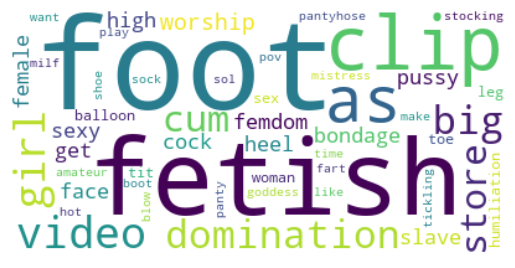

In [19]:
from wordcloud import *
word_freq = [i for i in counter.most_common(50)]
wd = WordCloud(background_color='white')
wd.generate_from_frequencies(dict(word_freq))
plt.figure()
plt.imshow(wd, interpolation = 'bilinear')
plt.axis('off')
plt.show()

In [22]:
train_size = int(data.shape[0] * .8)

train = data[:train_size]
val = data[train_size:]

# Split train and test

X_train = train.text_preprocessed.to_numpy()
y_train = train.labels.to_numpy()

X_val = val.text_preprocessed.to_numpy()
y_val = val.labels.to_numpy()

In [23]:
train.text_preprocessed.to_numpy()

array(['hot guy jack toy', 'zillemdom',
       'cum countdown vaping cuckolding pussy slapping lingerie as british red brunette femdom tease pov roleplay heel smoking british accent',
       ...,
       'danielle wearing mini skirt see blue panty also wearing little sport top fishnet white platform boot scissors slave really hard clip sexy strong powerful leg look face turn normal color deep purple girl extremely strong leg could end life',
       'tongue fetish sun shine',
       'cbt high heel reward tiny dick chastity hd wmv'], dtype=object)

In [24]:
X_train,  y_train

(array(['hot guy jack toy', 'zillemdom',
        'cum countdown vaping cuckolding pussy slapping lingerie as british red brunette femdom tease pov roleplay heel smoking british accent',
        ...,
        'danielle wearing mini skirt see blue panty also wearing little sport top fishnet white platform boot scissors slave really hard clip sexy strong powerful leg look face turn normal color deep purple girl extremely strong leg could end life',
        'tongue fetish sun shine',
        'cbt high heel reward tiny dick chastity hd wmv'], dtype=object),
 array([0, 0, 0, ..., 0, 0, 0]))

In [25]:
X_train.shape, X_val.shape

((69151,), (17288,))

# Tokenize

In [26]:
# vectorize a text corpus by turning each text into sentence of integers

tokenizer = Tokenizer(num_words=num_unique_words) #, oov_token=oov_token)
tokenizer.fit_on_texts(data.text_preprocessed.to_numpy())

In [27]:
import pickle

# # saving
with open('../models/tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# loading
# with open('../models/tokenizer.pickle', 'rb') as handle:
#     tokenizer = pickle.load(handle)

In [28]:
# each word have a unique index
word_index = tokenizer.word_index
word_index

{'foot': 1,
 'fetish': 2,
 'clip': 3,
 'as': 4,
 'video': 5,
 'girl': 6,
 'big': 7,
 'domination': 8,
 'store': 9,
 'cum': 10,
 'worship': 11,
 'cock': 12,
 'bondage': 13,
 'slave': 14,
 'face': 15,
 'heel': 16,
 'sexy': 17,
 'female': 18,
 'get': 19,
 'pussy': 20,
 'femdom': 21,
 'high': 22,
 'balloon': 23,
 'woman': 24,
 'toe': 25,
 'leg': 26,
 'sex': 27,
 'tit': 28,
 'humiliation': 29,
 'pantyhose': 30,
 'sol': 31,
 'shoe': 32,
 'boot': 33,
 'mistress': 34,
 'stocking': 35,
 'blow': 36,
 'like': 37,
 'play': 38,
 'time': 39,
 'pov': 40,
 'amateur': 41,
 'goddess': 42,
 'hot': 43,
 'want': 44,
 'make': 45,
 'milf': 46,
 'panty': 47,
 'sock': 48,
 'fart': 49,
 'tickling': 50,
 'fuck': 51,
 'fucking': 52,
 'crush': 53,
 'mouth': 54,
 'hand': 55,
 'love': 56,
 'see': 57,
 'black': 58,
 'orgasm': 59,
 'farting': 60,
 'job': 61,
 'tease': 62,
 'one': 63,
 'smoking': 64,
 'long': 65,
 'full': 66,
 'masturbation': 67,
 'spanking': 68,
 'hd': 69,
 'take': 70,
 'hard': 71,
 'dirty': 72,
 'les

In [29]:
word_index['sex']

27

In [ ]:
# Check reversing the indices

# flip (key, value)
reverse_word_index = dict([(idx, word) for (word, idx) in word_index.items()])
reverse_word_index

In [ ]:
# del word_index['<UNK>']
word_ind = dict()
for word, number in word_index.items():
    word_ind[word] = number + 3
    
word_ind["<UNKNOWN>"] = 0
word_ind["<FILLER>"] = 1
word_ind["<BEGINOFSEQUENCE>"] = 2
word_ind["<UNUSED>"] = 3

In [ ]:
len(word_ind)

In [ ]:
rvi = dict()

for key, value in word_ind.items():
    rvi[value] = key
rvi

# Find  vectors

In [ ]:
X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_val_sequences = tokenizer.texts_to_sequences(X_val)

In [ ]:
# pad the sequences to have the same length
from tensorflow.keras.preprocessing.sequence import pad_sequences

# max words in a sequence
max_length = 200 #max([len(x) for x in X_train_sequences]) #256

X_train_padded = pad_sequences(X_train_sequences, maxlen=max_length, padding="post", truncating="post")
X_val_padded = pad_sequences(X_val_sequences, maxlen=max_length, padding="post", truncating="post")

X_train_padded.shape, X_val_padded.shape

In [ ]:
print(X_train[10])
print(X_train_sequences[10])
print(X_train_padded[10])

In [ ]:
def decode(sequence):
    return " ".join([rvi.get(idx, "?") for idx in sequence])

decoded_text = decode(X_train_sequences[10])

print(X_train_sequences[10])
print(decoded_text)

# Tensorflow

In [ ]:
# # Create LSTM model
# from tensorflow.keras import layers

# # Word embeddings give us a way to use an efficient, dense representation in which similar words have
# # a similar encoding. Importantly, you do not have to specify this encoding by hand. An embedding is a 
# # dense vector of floating point values (the length of the vector is a parameter you specify)

max_length = 200 
# embedding_vector_features=45 # 32

# # 
# # tf.debugging.set_log_device_placement(True)

# model = keras.models.Sequential()
# model.add(layers.Embedding(num_unique_words, embedding_vector_features, input_length=max_length))

# # The layer will take as input as integer matrix of size (batcg, input_length)
# # and the largest integer (i.e. word index) in the input should be no larger than num_words (vocabulary size).
# # Now model.output_shape is (None, input_length, 32), where `None` is the batch dimension.

# model.add(layers.LSTM(64, dropout=.10)) # dropout=.1
# model.add(layers.Dense(1, activation='sigmoid'))

# model.summary()

In [ ]:
# from tensorflow.keras import layers

# embedding_vector_features=45

# model=keras.models.Sequential()

# model.add(layers.Embedding(num_unique_words, embedding_vector_features,input_length=max_length))

# model.add(layers.LSTM(128, return_sequences=True))#dropout=.10
 
# model.add(layers.Dropout(0.2))

# model.add(layers.LSTM(128,activation='relu'))

# model.add(layers.Dropout(0.2))

# # for units in [128,128,64,32]:

# # model.add(Dense(units,activation='relu'))

# # model.add(Dropout(0.2))

# model.add(layers.Dense(32,activation='relu'))

# model.add(layers.Dropout(0.2))

# model.add(layers.Dense(1,activation='sigmoid'))

# #####Compile
# loss = keras.losses.BinaryCrossentropy(from_logits=False)
# optimizer = keras.optimizers.legacy.Adam(learning_rate=.01)
# metrics = ['accuracy']
# # metrics = [tf.keras.metrics.BinaryAccuracy(),
# #            tf.keras.metrics.FalseNegatives(),
# #            tf.keras.metrics.FalsePositives(),
# #           ]
# model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

# print(model.summary())

In [ ]:
import numpy as np
from keras.datasets import imdb
from keras.layers import LSTM, Embedding, Dense, Dropout

model = keras.models.Sequential()
model.add(Embedding(num_unique_words, 32, input_length=max_length))
#model.add(LSTM(100))
model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
model.add(Dropout(0.5))
model.add(Dense(8))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

loss = keras.losses.BinaryCrossentropy(from_logits=False)
optimizer = keras.optimizers.legacy.Adam(learning_rate=.01)
metrics = ['accuracy']
# metrics = [tf.keras.metrics.BinaryAccuracy(),
#            tf.keras.metrics.FalseNegatives(),
#            tf.keras.metrics.FalsePositives(),
#           ]
model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

print(model.summary())

In [ ]:
# draw model
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
from pathlib import Path
from tensorflow.keras.models import load_model

path = Path('../models/bad_words')
path.mkdir(exist_ok=True) 
cpt_filename = '{epoch:02d}_checkpoint_{val_loss:.2f}.hdf5'
cpt_path = str(path / cpt_filename)

checkpoint = tf.keras.callbacks.ModelCheckpoint(cpt_path, monitor='val_loss', verbose=1, 
                                                save_best_only=True, mode='min')

In [ ]:
loss = keras.losses.BinaryCrossentropy(from_logits=False)
optimizer = keras.optimizers.legacy.Adam(learning_rate=.01)
metrics = ['accuracy']
# metrics = [tf.keras.metrics.BinaryAccuracy(),
#            tf.keras.metrics.FalseNegatives(),
#            tf.keras.metrics.FalsePositives(),
#           ]
model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

In [ ]:
model.fit(X_train_padded, y_train, epochs=5, batch_size=64, validation_data=(X_val_padded, y_val), verbose=1, 
          callbacks=[checkpoint, PlotLossesCallback()])

In [ ]:
history_df = pd.DataFrame(model.history.history)
history_df.head(15)

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history_df.loss)
plt.xlabel('Эпоха обучения')
plt.ylabel('Количество ошибок');

In [ ]:
plt.plot(history_df.accuracy,
         label='Доля верных ответов на обучающей выборке')
plt.plot(history_df.val_accuracy,
         label='Доля верных ответов на валидационной выборке')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

In [ ]:
embeddlayers_matrix = model.layers[0].get_weights()[0]
embeddlayers_matrix[30]

In [ ]:
word = 'sex'
word_number = word_ind[word]
print('Номер слова', word_number)
print('Вектор для слова', embeddlayers_matrix[word_number])

In [ ]:
filename = '../datasets/embeds.csv'

In [ ]:
rvi = dict()

for key, value in word_ind.items():
    rvi[value] = key
rvi

In [ ]:
# with open(filename, 'w') as f:
#     for word_num in range(num_unique_words):
#         word = rvi[word_num]
#         vec = embeddlayers_matrix[word_num]
#         f.write(word + ',')
#         f.write(','.join([str(x) for x in vec]) + '\n')

In [ ]:
!head -n20 $filename

In [ ]:
rvi[30]

In [ ]:
!ls '../models/bad_words'

In [ ]:
model.load_weights('../models/bad_words/04_checkpoint_0.05.hdf5') # loading weights - model had created erlier
loss, acc = model.evaluate(X_val_padded, y_val)
print(f'Accuracy of restored model {acc*100:.2f}%')

In [ ]:
base_model = tf.keras.models.load_model('../models/bad_words/04_checkpoint_0.05.hdf5')
# base_model.trainable = False # замораживаем базовую модель

loss, acc = base_model.evaluate(X_val_padded, y_val)
print(f'Accuracy of restored model {acc*100:.2f}%')

In [ ]:
predictions = model.predict(X_train_padded)
predictions = [1 if p > .5 else 0 for p in predictions]

In [ ]:
X_train_padded[1200:1210]

In [ ]:
print(X_train[1200:1210])
print(y_train[1200:1210])
print(predictions[1200:1210])

In [ ]:
train['predictions'] = predictions
train = train[['text_preprocessed', 'labels', 'predictions', 'text']] # columns reorder

In [ ]:
train.head(11)

In [ ]:
train.to_csv('../datasets/wo_html.csv')

In [ ]:
# model.save('../models/bad_words/modelSequential_HTML_final.h5')
# model = keras.models.load_model('../models/modelSequential_HTML_final.h5')

In [ ]:
# model_new = keras.models.load_model('../models/modelSequential_wo_HTML.h5')
# model_new = keras.models.load_model('../models/bad_words/08_checkpoint_0.07.hdf5')

In [ ]:
# with open('../datasets/sub.txt', 'r') as file:
#     raw_text = ''.join(file.readlines())

# raw_text

In [ ]:
def read_train_data():
    data = pd.read_json('../datasets/dataset.json')
    mapping = {False: 0, True: 1}
    data.replace({'hasBadWords': mapping}, inplace=True)
    data.rename(columns={"hasBadWords": "labels"}, inplace=True)
    data.rename(columns={"text": "raw_text"}, inplace=True)
    data.drop(['violation'], axis=1, inplace=True)
    print('Data size %d' % len(data))
    print('Data headers %s' % data.columns.values)
    return data

In [ ]:
df_pos = pd.read_csv('../datasets/BadWordsService_ml_has_7days.csv')
df_neg =  pd.read_csv('../datasets/BadWordsService_ml_has_no_7days.csv')
df_val = pd.read_csv('../datasets/BadWordsService_ml_has_today.csv')

In [ ]:
df_pos.drop('@timestamp', axis=1, inplace=True)
df_neg.drop('@timestamp', axis=1, inplace=True)
df_val.drop('@timestamp', axis=1, inplace=True)
df_val['ctxt_.time_spent'] = df_val['ctxt_.time_spent'] * 1000 # convert seconds to milliseconds

In [ ]:
df_pos.rename(columns={"ctxt_.text": "raw_text", "ctxt_.time_spent": "time_spent_ms"}, inplace=True)
df_neg.rename(columns={"ctxt_.text": "raw_text", "ctxt_.time_spent": "time_spent_ms"}, inplace=True)
df_val.rename(columns={"ctxt_.text": "raw_text"}, inplace=True)
df_val.rename(columns={"ctxt_.time_spent": "time_spent_ms"}, inplace=True)

In [ ]:
df_pos.head()

In [ ]:
df_neg.head()

In [ ]:
df_val.head()

In [ ]:
df_pos['labels'] = 1
df_neg['labels'] = 0

In [ ]:
df_pos.head()

In [ ]:
df_neg.head()

In [ ]:
nan_values_neg = df_neg[df_neg.isna().any(axis=1)]
print(len(nan_values_neg))

# nan_values_pos = df_pos[df_pos.isna().any(axis=1)]
# print(len(nan_values_pos))

nan_values = df_val[df_val.isna().any(axis=1)]
print(len(nan_values))

In [ ]:
df_neg.dropna(inplace=True)
df_neg.head()

In [ ]:
df_pos['text'] = df_pos.apply(lambda row: clean_text(row.raw_text), axis=1)
df_neg['text'] = df_neg.apply(lambda row: clean_text(row.raw_text), axis=1)
df_val['text'] = df_val.apply(lambda row: clean_text(row.raw_text), axis=1)

In [ ]:
df_pos.head()

In [ ]:
df_neg.head()

In [ ]:
df_val.head()

In [ ]:
df_pos.drop('raw_text', axis=1, inplace=True)
df_neg.drop('raw_text', axis=1, inplace=True)
df_val.drop('raw_text', axis=1, inplace=True)

In [ ]:
df_pos.shape, df_neg.shape, df_val.shape

In [ ]:
from sklearn.utils import shuffle
RANDOM_STATE = 42

df_tra = pd.concat([df_pos, df_neg], ignore_index=True)
df_tra = shuffle(df_tra, random_state=RANDOM_STATE).reset_index(drop=True)

df_tra.shape

In [ ]:
df_tra.head()

In [ ]:
df_tra = df_tra[['text', 'labels']]#, 'raw_text']] # columns reorder
df_tra.head()

In [ ]:
df_val.head()

In [ ]:
counter

In [ ]:
from wordcloud import *
word_freq = [i for i in counter.most_common(50)]
wd = WordCloud(background_color='white')
wd.generate_from_frequencies(dict(word_freq))
plt.figure()
plt.imshow(wd, interpolation = 'bilinear')
plt.axis('off')
plt.show()

In [ ]:
train_size = int(df_tra.shape[0] * .8)

train = df_tra[:train_size]
val = df_tra[train_size:]

# Split train and test

X_train = train.text.to_numpy()
y_train = train.labels.to_numpy()

X_val = val.text.to_numpy()
y_val = val.labels.to_numpy()

In [ ]:
# X = df.text.to_numpy()

In [ ]:
X_train,  y_train

In [ ]:
X_train.shape, X_val.shape

In [ ]:
import pickle

# # loading
with open('../models/tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

In [ ]:
# vectorize a text corpus by turning each text into sentence of integers

# tokenizer = Tokenizer(num_words=num_unique_words) #, oov_token=oov_token)
# tokenizer.fit_on_texts(X)

In [ ]:
# each word have a unique index
word_index = tokenizer.word_index
word_index['sex']

In [ ]:
len(word_index.keys())

In [ ]:
X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_val_sequences = tokenizer.texts_to_sequences(X_val)

In [ ]:
print(X_train[1])
print(X_train_sequences[1])

In [ ]:
# pad the sequences to have the same length
from tensorflow.keras.preprocessing.sequence import pad_sequences

# max words in a sequence
max_length = 200 #max([len(x) for x in X_train_sequences]) #256

X_train_padded = pad_sequences(X_train_sequences, maxlen=max_length, padding="post", truncating="post")
X_val_padded = pad_sequences(X_val_sequences, maxlen=max_length, padding="post", truncating="post")

X_train_padded.shape, X_val_padded.shape

In [ ]:
print(X_train[10])
print(X_train_sequences[10])
print(X_train_padded[10])

In [ ]:
# Check reversing the indices

# flip (key, value)
reverse_word_index = dict([(idx, word) for (word, idx) in word_index.items()])
reverse_word_index

In [ ]:
# tf.debugging.set_log_device_placement(True)

model = keras.models.Sequential([model,
                                 layers.Embedding(num_unique_words, 32, input_length=max_length),
                                 layers.LSTM(64, dropout=.10),
                                 layers.Dense(1, activation='sigmoid')
                                ])

model.summary()

In [ ]:
loss = keras.losses.BinaryCrossentropy(from_logits=False)
optimizer = keras.optimizers.legacy.Adam(learning_rate=.001)
metrics = ['accuracy']

model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

model.fit(X_train_padded, y_train, epochs=25, batch_size=64, validation_data=(X_val_padded, y_val), verbose=1, 
          callbacks=[checkpoint])

# model.fit(X_train_padded, y_train, epochs=15, validation_data=(X_val_padded, y_val), verbose=1, 
#           callbacks=[checkpoint])

In [ ]:
history_df = pd.DataFrame(model.history.history)
history_df.head(15)

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history_df.loss);

# Check sentence

In [ ]:
#preprocessing
import re
import pymorphy2
import nltk
from datetime import datetime 
from nltk.corpus import stopwords  #stopwords
from nltk import word_tokenize,sent_tokenize # tokenizing
from nltk.stem import PorterStemmer,LancasterStemmer  # using the Porter Stemmer and Lancaster Stemmer and others
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer  # lammatizer from WordNet
import matplotlib.pyplot as plt
import string
# pad the sequences to have the same length
from tensorflow.keras.preprocessing.sequence import pad_sequences


######## new
import itertools as itt
chunksize = 200
    
# vectorize a text corpus by turning each text into sentence of integers
max_len = 200
# tokenizer = Tokenizer(num_words=num_unique_words, oov_token=oov_token)
# tokenizer.fit_on_texts(X)


values = []
columns = ['text', 'time_elapsed_ms','label']
for index, elem in enumerate(df_val.text):
    start_time = datetime.now() 
    cnt = itt.count()
    test_text_np = np.array([''.join(grp) for k, grp in itt.groupby(elem, key=lambda x: next(cnt)//chunksize%2)])
    tokenizer.fit_on_texts(test_text_np)
    test_sequences = tokenizer.texts_to_sequences(test_text_np)   
    test_sequences_padded = pad_sequences(test_sequences, maxlen=max_len, padding="post", truncating="post")
#     print(test_text_np)
#     print('LEN', len(test_text_np))
#     print('test_sequences', test_sequences)
#     print('test_sequences_padded', test_sequences_padded)
    
    # for word in test_text_preprocessed:
    # Get max training sequence length
  

    tf.config.run_functions_eagerly(True)
    predictions = model.predict(test_sequences_padded)
    predictions = [1 if p > .5 else 0 for p in predictions]

    time_elapsed = datetime.now() - start_time 

#     print('Time elapsed (ms) {}'.format(time_elapsed.microseconds/1000))
#     print('Prediction:', max(predictions))
    if elem not in values:
#         print('**************', index, '~~~~~~~~~~~', elem, values[index-1])
        values.append([elem, round(time_elapsed.microseconds/1000, 1), max(predictions)])
        values[index][1] += round(time_elapsed.microseconds/1000, 1)
#         print('**************', index, '~~~~~~~~~~~', elem, '################', values[index][1])
df_result = pd.DataFrame(data=values, columns=columns)
########
# test_text_np = np.array([test_text_preprocessed])
# test_sequences = tokenizer.texts_to_sequences(test_text_np)

In [ ]:
# del(df_result)
df_result.head()

In [ ]:
df_val.head()

In [ ]:
df_result.head()

In [ ]:
df_united = df_val.merge(df_result, right_on='text', left_on='text')
df_united['time_delta'] = df_united.time_spent_ms - df_united.time_elapsed_ms
df_united = df_united[['text', 'time_spent_ms', 'time_elapsed_ms', 'time_delta', 'label']]
df_united.drop_duplicates(['text'], keep='last', ignore_index=True, inplace=True)

In [ ]:
df_united.head(20)

In [ ]:
df_united.to_csv('../datasets/last_pred_old.csv')

In [ ]:
######## new
import itertools as itt
chunksize = 200
max_len = chunksize

# raw_text = "After a morning of horse-back riding, Sara Domina returns home with her boots dirtied, the soles soiled with .....Her slave is in waiting, unawares of what is about to happen to him ....."
raw_text = """nymphomaniac forced submission wmv"""

test_text_preprocessed = [clean_text(raw_text)]
# print(test_text_preprocessed)
values = []
columns = ['text', 'time_elapsed_ms','label']
for index, elem in enumerate(test_text_preprocessed):
    start_time = datetime.now() 
    cnt = itt.count()
    test_text_np = np.array([''.join(grp) for k, grp in itt.groupby(elem, key=lambda x: next(cnt)//chunksize%2)])
    tokenizer.fit_on_texts(test_text_np)
    test_sequences = tokenizer.texts_to_sequences(test_text_np)   
    test_sequences_padded = pad_sequences(test_sequences, maxlen=max_len, padding="post", truncating="post")
#     print(test_text_np)
#     print('LEN', len(test_text_np))
#     print('test_sequences', test_sequences)
#     print('test_sequences_padded', test_sequences_padded)
    
    # for word in test_text_preprocessed:
    # Get max training sequence length
  

    tf.config.run_functions_eagerly(True)
    predictions = model.predict(test_sequences_padded)
    predictions = [1 if p > .5 else 0 for p in predictions]

    time_elapsed = datetime.now() - start_time 

#     print('Time elapsed (ms) {}'.format(time_elapsed.microseconds/1000))
#     print('Prediction:', max(predictions))
    if elem not in values:
#         print('**************', index, '~~~~~~~~~~~', elem, values[index-1])
        values.append([elem, round(time_elapsed.microseconds/1000, 1), max(predictions)])
        values[index][1] += round(time_elapsed.microseconds/1000, 1)
#         print('**************', index, '~~~~~~~~~~~', elem, '################', values[index][1])
df_result = pd.DataFrame(data=values, columns=columns)
df_result
# ####### new
# myseq = raw_text
# cnt = itt.count()
# test_text_np = np.array([''.join(grp) for k,grp in itt.groupby(myseq, key=lambda x: next(cnt)//chunksize%2)])
# test_sequences = tokenizer.texts_to_sequences(test_text_np)
# #######

# test_text_np = np.array([test_text_preprocessed])
# test_sequences = tokenizer.texts_to_sequences(test_text_np)

In [ ]:
test_text_np[0]

In [ ]:
test_sequences[0]

In [ ]:
# for word in test_text_preprocessed:
# Get max training sequence length
max_len = 200

test_sequences_padded = pad_sequences(test_sequences, maxlen=max_len, padding="post", truncating="post")

In [ ]:
print(test_text_np)
print(test_sequences)
print(test_sequences_padded)

In [ ]:
start_time = datetime.now() 

predictions = model.predict(test_sequences_padded)
predictions = [1 if p > .5 else 0 for p in predictions]

time_elapsed = datetime.now() - start_time 

print('Time elapsed (hh:mm:ss.ms) {}'.format(time_elapsed))


In [ ]:
max(predictions)

In [ ]:
# %%time

# predictions = model_new.predict(test_sequences_padded)
# predictions = [1 if p > .5 else 0 for p in predictions]